### Import Headers

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np
import cv2
import glob
import time
import pickle
import os.path
from random import randint

from collections import deque

from scipy.ndimage.measurements import label

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from sklearn.model_selection import train_test_split


### HOG Data Storage class

This class manages the file names and directory structures that will be used for training the HOG

In [4]:

## LOAD DATA ##

class HOG_Data_Storage:
    
    _carImages = []
    _nonCarImages = []
    
    # folders containing non car images
    _baseNonCarFolder = "training_data/non-vehicles/"
    _nonCarFolders = ["extras", "GTI"]
    
    # folders containing car images
    _baseCarFolder = "training_data/vehicles/"
    _carFolders = ["GTI_Far", "GTI_Left", "GTI_MiddleClose", "GTI_Right"]#, "KITTI_extracted"]
    
    def load_training_sets(self):
    
        self._carImages = []
        self._nonCarImages = []
    
        # Load non-car folders
        for folder in self._nonCarFolders:
            path = self._baseNonCarFolder + folder

            images = glob.glob(path + '/*.png')

            self._nonCarImages += images

        # Load car folders
        for folder in self._carFolders:
            path = self._baseCarFolder + folder

            images = glob.glob(path + '/*.png')

            self._carImages += images

        print('Files Loaded and ready for parsing...')
        print('number of car images: ', len(self._carImages))    
        print('number of non-car images: ', len(self._nonCarImages))

### Feature_manager class

This class manages all aspects of building HOG filter, extracting the color features, and training the SVC or other selected classifier. It is also used to extract features for the target at runtime.

In [5]:
class Feature_manager():
    
    _svcModelFilename = "svc_car_detect.sav" # where parameters are saved to
    
    ########################
    _color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    _orient = 9  # HOG orientations
    _pix_per_cell = 8 # HOG pixels per cell
    _cell_per_block = 8 # HOG cells per block
    _hog_channel = 0 # Can be 0, 1, 2, or "ALL"
    _spatial_size = (24, 24) # Spatial binning dimensions
    _hist_bins = 24    # Number of histogram bins
    _spatial_feat = True # Spatial features on or off
    _hist_feat = False # Histogram features on or off
    _hog_feat = True # HOG features on or off
    ########################
    
    _svc = None # classifier
    _Scaler = None # data scaler
    
    
    def load_HOG_svc(self):
        
        if os.path.isfile(self._svcModelFilename):
            
            # load the model from disk
            #self._svc = pickle.load(open(self._svcModelFilename, 'rb'))
            
            with open(self._svcModelFilename,"rb") as f:
                self._color_space  = pickle.load(f)
                self._orient       = pickle.load(f)
                self._pix_per_cell   = pickle.load(f)
                self._cell_per_block = pickle.load(f)
                self._hog_channel  = pickle.load(f)
                self._spatial_size = pickle.load(f)
                self._hist_bins    = pickle.load(f)
                self._spatial_feat = pickle.load(f)
                self._hist_feat    = pickle.load(f)
                self._hog_feat     = pickle.load(f)
                
                self._svc      = pickle.load(f)
                self._X_scaler = pickle.load(f)
                
            print("model loaded")
            
        else:
            self._svc = None
            self._X_scaler = None
            
            print("model file not found")
    
    def save_HOG_svc(self):
        
        # save the model to disk
        #pickle.dump(self._svc, open(self._svcModelFilename, 'wb'))
        
        with open(self._svcModelFilename,"wb") as f:
            pickle.dump(self._color_space, f)
            pickle.dump(self._orient, f)
            pickle.dump(self._pix_per_cell, f)
            pickle.dump(self._cell_per_block, f)
            pickle.dump(self._hog_channel, f)
            pickle.dump(self._spatial_size, f)
            pickle.dump(self._hist_bins, f)
            pickle.dump(self._spatial_feat, f)
            pickle.dump(self._hist_feat, f)
            pickle.dump(self._hog_feat, f)
            
            pickle.dump(self._svc, f)
            pickle.dump(self._X_scaler, f)
        
        print("model saved!")
        
    def convert_color(self, image, color_space='RGB'):
        
        if color_space != 'RGB':
            if color_space == 'RGB2HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'RGB2LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'RGB2HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'RGB2YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'RGB2YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif color_space == 'BGR2HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'BGR2LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'BGR2HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'BGR2YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'BGR2YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
            elif color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)  
            
        return feature_image
    
    # HOG Functions
    # Define a function to return HOG features and visualization
    def get_hog_features(self, img, orient, pix_per_cell, cell_per_block, 
                         vis=False, feature_vec=True):

        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=True, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=True, 
                           visualise=vis, feature_vector=feature_vec)
            return features
        
    # Define a function to compute binned color features  
    def bin_spatial(self, img, size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features

    # Define a function to compute color histogram features 
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    def color_hist(self, img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features

    # Define a function to extract features from a list of images
    # Have this function call bin_spatial() and color_hist()
    def extract_features_list(self, imgs, color_space='RGB', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=0,
                            spatial_feat=True, hist_feat=True, hog_feat=True):
        # Create a list to append feature vectors to
        features = []
        
        # Iterate through the list of images
        for file in imgs:
            
            # Read in each one by one
            image = mpimg.imread(file)
            
            img_features = self.extract_features(image, color_space, spatial_size,
                                            hist_bins, orient, 
                                            pix_per_cell, cell_per_block, hog_channel,
                                            spatial_feat, hist_feat, hog_feat)
            
            features.append(img_features)
            
        return features
            
    
    # Define a function to extract features from a list of images
    # Have this function call bin_spatial() and color_hist()
    def extract_features(self, image, color_space='RGB', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=0,
                            spatial_feat=True, hist_feat=True, hog_feat=True):


        img_features = []
        
           
        feature_image = self.convert_color(image, color_space)

        if spatial_feat == True:
            spatial_features = self.bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = self.color_hist(feature_image, nbins=hist_bins)
            img_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(self.get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)  
            else:
                hog_features = self.get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
            # Append the new feature vector to the features list
            img_features.append(hog_features)
                
        return np.concatenate(img_features)
    
    def train(self, carImages, nonCarImages):
        # Process images and train HOG

        # Reduce the sample size because HOG features are slow to compute if we are in test mode

        cars = carImages
        notcars = nonCarImages

        t=time.time()
        
        car_features = self.extract_features_list(  cars, color_space=self._color_space, 
                                                    spatial_size=self._spatial_size, hist_bins=self._hist_bins, 
                                                    orient=self._orient, pix_per_cell=self._pix_per_cell, 
                                                    cell_per_block=self._cell_per_block, 
                                                    hog_channel=self._hog_channel, spatial_feat=self._spatial_feat, 
                                                    hist_feat=self._hist_feat, hog_feat=self._hog_feat)
        
        notcar_features = self.extract_features_list(notcars, color_space=self._color_space, 
                                                     spatial_size=self._spatial_size, hist_bins=self._hist_bins, 
                                                     orient=self._orient, pix_per_cell=self._pix_per_cell, 
                                                     cell_per_block=self._cell_per_block, 
                                                     hog_channel=self._hog_channel, spatial_feat=self._spatial_feat, 
                                                     hist_feat=self._hist_feat, hog_feat=self._hog_feat)

        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to extract HOG features...')
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        self._X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = self._X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

        print('Using:',self._orient,'orientations',self._pix_per_cell, 'pixels per cell and', self._cell_per_block,'cells per block')
        
        print('Feature vector length:', len(X_train[0]))
        
        # Use a linear SVC 
        self._svc = LinearSVC()
        
        # Check the training time for the SVC
        t=time.time()
        self._svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(self._svc.score(X_test, y_test), 4))
        
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        print('My SVC predicts: ', self._svc.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
        
        # save the model so we don't need to do this everytime
        self.save_HOG_svc()
        
        
    def generate_features_from_image(self, image, orient = 9, pix_per_cell = 8, cell_per_block = 2):
        
        feature_array = hog(image, 
                            orientations=orient, 
                            pixels_per_cell=(pix_per_cell, pix_per_cell), 
                            cells_per_block=(cell_per_block, cell_per_block), 
                            visualise=False, 
                            feature_vector=False)
        

        return feature_array
        

### Explore the data and see what we have

Files Loaded and ready for parsing...
number of car images:  2826
number of non-car images:  8968
Loading new file....
color space being shown: RGB2HSV


C:\Users\James\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


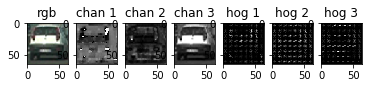

C:\Users\James\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)
C:\Users\James\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:190: RuntimeWarning: invalid value encountered in remainder
  orientations, orientation_histogram)


color space being shown: RGB2LUV


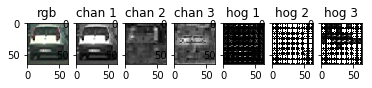

color space being shown: RGB2HLS


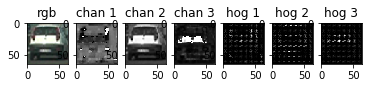

color space being shown: RGB2YUV


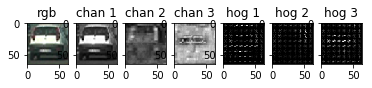

color space being shown: RGB2YCrCb


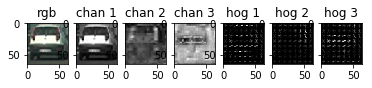

Loading new file....
color space being shown: RGB2HSV


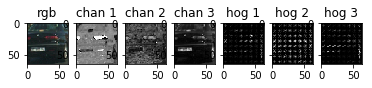

color space being shown: RGB2LUV


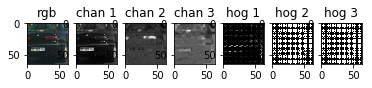

color space being shown: RGB2HLS


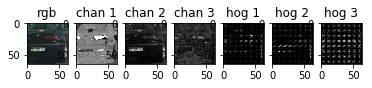

color space being shown: RGB2YUV


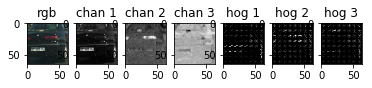

color space being shown: RGB2YCrCb


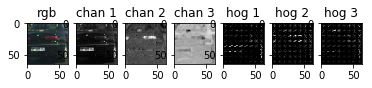

Loading new file....
color space being shown: RGB2HSV


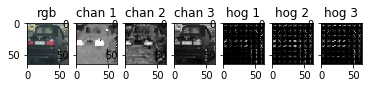

color space being shown: RGB2LUV


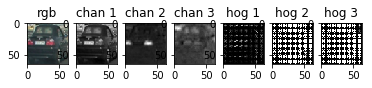

color space being shown: RGB2HLS


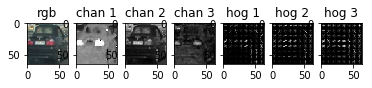

color space being shown: RGB2YUV


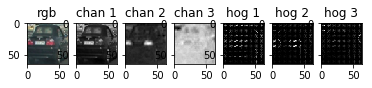

color space being shown: RGB2YCrCb


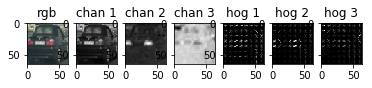

Loading new file....
color space being shown: RGB2HSV


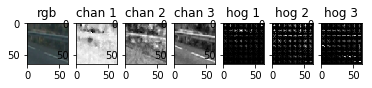

color space being shown: RGB2LUV


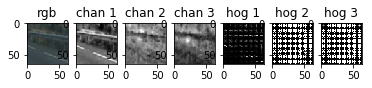

color space being shown: RGB2HLS


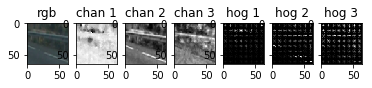

color space being shown: RGB2YUV


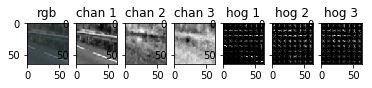

color space being shown: RGB2YCrCb


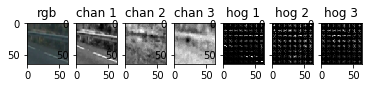

Loading new file....
color space being shown: RGB2HSV


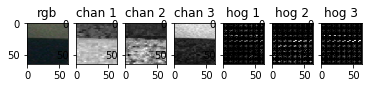

color space being shown: RGB2LUV


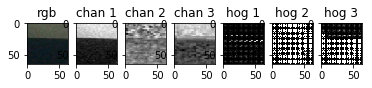

color space being shown: RGB2HLS


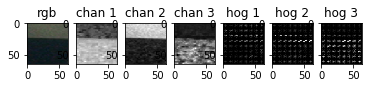

color space being shown: RGB2YUV


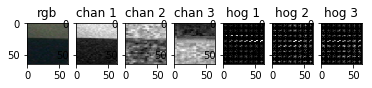

color space being shown: RGB2YCrCb


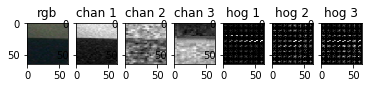

Loading new file....
color space being shown: RGB2HSV


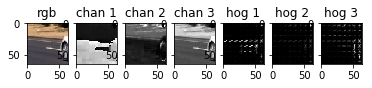

color space being shown: RGB2LUV


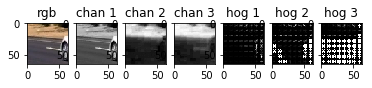

color space being shown: RGB2HLS


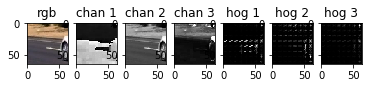

color space being shown: RGB2YUV


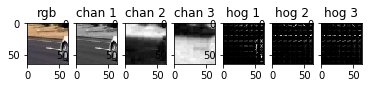

color space being shown: RGB2YCrCb


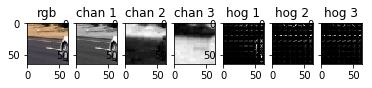

In [6]:
def get_random_images(options, countToGet):
    
    values = []
    
    for i in range(countToGet):
        idx = randint(0, len(options))
        
        values.append(options[idx])
        
    return values
    
def explore_images():
    
    # load up some data
    datStore = HOG_Data_Storage()
    datStore.load_training_sets()
    
    # get handle to HOG manager
    hogMgr = Feature_manager()
    
    #define the color spaces we want to check out...
    color_spaces = ['RGB2HSV', 'RGB2LUV', 'RGB2HLS', 'RGB2YUV', 'RGB2YCrCb']
    
    
    files = get_random_images(datStore._carImages, 3) + get_random_images(datStore._nonCarImages, 3)
    
    im_count = 1
    
    # loop through each test file
    for file in files:
        
        print('Loading new file....')
        
        # load a file
        image = mpimg.imread(file)

        # look at all color space alternatives for current file
        for color_space in color_spaces:

            img = hogMgr.convert_color(image, color_space)

            # explore each channel seperately
            c1 = img[:,:,0]
            c2 = img[:,:,1]
            c3 = img[:,:,2]

            # get HOG on each channel and visualize it
            _, h1 = hogMgr.get_hog_features(c1, hogMgr._orient, hogMgr._pix_per_cell, hogMgr._cell_per_block, vis=True, feature_vec=False)
            _, h2 = hogMgr.get_hog_features(c2, hogMgr._orient, hogMgr._pix_per_cell, hogMgr._cell_per_block, vis=True, feature_vec=False)
            _, h3 = hogMgr.get_hog_features(c3, hogMgr._orient, hogMgr._pix_per_cell, hogMgr._cell_per_block, vis=True, feature_vec=False)

            # clear all plots
            plt.close('all')
            
            plt.figure()

            # plot all images in a row...

            print('color space being shown: ' + color_space)
            
            f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7)
            ax1.imshow(image)
            ax1.set_title('rgb')
            ax2.imshow(c1, cmap='gray')
            ax2.set_title('chan 1')
            ax3.imshow(c2, cmap='gray')
            ax3.set_title('chan 2')
            ax4.imshow(c3, cmap='gray')
            ax4.set_title('chan 3')
            ax5.imshow(h1, cmap='gray')
            ax5.set_title('hog 1')
            ax6.imshow(h2, cmap='gray')
            ax6.set_title('hog 2')
            ax7.imshow(h3, cmap='gray')
            ax7.set_title('hog 3')

            out_name = 'output_images/' + str(im_count) + color_space + '.png'
            plt.savefig(out_name)
            
            plt.show()
            
        im_count+=1
    
    
explore_images()

### hog_search_window_manager class

Class to manage all aspect of searching the target image for windows that contain our target features

In [7]:
## window search
class hog_search_window_manager():
    
    _hog_object = None
    
    def __init__(self, hog_obj=None):
        self._hog_object = hog_obj

    # Here is your draw_boxes function from the previous exercise
    def draw_boxes(self, img, bboxes, color=(0, 0, 255), thick=6):
        # Make a copy of the image
        imcopy = np.copy(img)
        # Iterate through the bounding boxes
        for bbox in bboxes:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        # Return the image copy with boxes drawn
        return imcopy

    # Define a function that takes an image,
    # start and stop positions in both x and y, 
    # window size (x and y dimensions),  
    # and overlap fraction (for both x and y)
    def slide_window(self,  img, x_start_stop=(None, None), y_start_stop=(None, None), 
                            xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
        # Compute the span of the region to be searched    
        # Compute the number of pixels per step in x/y
        # Compute the number of windows in x/y
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        #     Note: you could vectorize this step, but in practice
        #     you'll be considering windows one by one with your
        #     classifier, so looping makes sense
            # Calculate each window position
            # Append window position to list
        # Return the list of windows

        imWidth  = img.shape[1]
        imHeight = img.shape[0]

        box_start = (0, 0)
        box_stop = (imWidth, imHeight)


        if x_start_stop[0] is not None:
            box_start[0] = x_start_stop[0]
        if x_start_stop[1] is not None:
            box_stop[0] = x_start_stop[1]

        if y_start_stop[0] is not None:
            box_start[1] = y_start_stop[0]
        if y_start_stop[1] is not None:
            box_stop[1] = y_start_stop[1]



        window_step = (int(xy_window[0] * (1-xy_overlap[0])),
                       int(xy_window[1] * (1-xy_overlap[1])))

        search_box = (box_stop[0] - box_start[0], 
                      box_stop[1]  - box_start[1])

        step_count = ((search_box[0] // window_step[0] -1),
                      (search_box[1] // window_step[1] -1))


        for y in range(0, step_count[1]):
            for x in range(0, step_count[0]):

                new_pos_start = (box_start[0] + x * window_step[0],
                                 box_start[1] + y* window_step[1])

                new_pos_stop = (new_pos_start[0] + xy_window[0], new_pos_start[1] + xy_window[1])

                window_list.append((new_pos_start, new_pos_stop))

        return window_list
    
    # Define a function you will pass an image 
    # and the list of windows to be searched (output of slide_windows())
    def search_windows(self, img, windows, clf, scaler, color_space='RGB', 
                        spatial_size=(32, 32), hist_bins=32, 
                        hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, 
                        hog_channel=0, spatial_feat=True, 
                        hist_feat=True, hog_feat=True):

        #1) Create an empty list to receive positive detection windows
        on_windows = []
        #2) Iterate over all windows in the list
        for window in windows:
            #3) Extract the test window from original image
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
            #4) Extract features for that window using single_img_features()
            features = self._hog_object.extract_features(test_img, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            #5) Scale extracted features to be fed to classifier
            test_features = scaler.transform(np.array(features).reshape(1, -1))
            #6) Predict using your classifier
            prediction = clf.predict(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
        #8) Return windows for positive detections
        return on_windows
    
    # Define a single function that can extract features using hog sub-sampling and make predictions
    def find_cars(self, img, draw_img, ystart, ystop, scale, svc, X_scaler, 
                  color_space, hog_channel, orient, pix_per_cell, cell_per_block, 
                  spatial_feat, spatial_size, 
                  hist_feat, hist_bins,
                  always_draw_windows = False, window_color=(255,0,0)):

        #draw_img = np.copy(img)
        img = img.astype(np.float32)/255
        
        col_space = 'BGR2' + color_space # assumes incoming image is in BGR format (opencv standard format)

        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = self._hog_object.convert_color(img_tosearch, color_space=col_space)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        #cells_per_step = 2  # Instead of overlap, define how many cells to step
        cells_per_step = pix_per_cell//2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image - only the want to use 
        # though as this is CPU expensive!
        hog1 = None
        hog2 = None
        hog3 = None
        if hog_channel == 'ALL' or hog_channel == 0:
            hog1 = self._hog_object.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        if hog_channel == 'ALL' or hog_channel == 1:
            hog2 = self._hog_object.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        if hog_channel == 'ALL' or hog_channel == 2:
            hog3 = self._hog_object.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        detected_bboxes = []
        
        #loop through the windows
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                # Extract HOG for this patch
                hog_feat_list = []
                if hog1 is not None:
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat_list.append(hog_feat1)
                if hog2 is not None:
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat_list.append(hog_feat2)
                if hog3 is not None:
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat_list.append(hog_feat3)
                #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                hog_features = np.hstack(hog_feat_list)

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = None
                hist_features = None

                # only compute the features we want to use as this is CPU expensive
                if spatial_feat:
                    spatial_features = self._hog_object.bin_spatial(subimg, size=spatial_size)
                if hist_feat:
                    hist_features = self._hog_object.color_hist(subimg, nbins=hist_bins)

                final_feature_list = []
                if spatial_features is not None:
                    final_feature_list.append(spatial_features)
                if hist_features is not None:
                    final_feature_list.append(hist_features)
                if hog_features is not None:
                    final_feature_list.append(hog_features)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack(final_feature_list).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    

                test_prediction = svc.predict(test_features)

                if test_prediction == 1 or always_draw_windows:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),window_color,4) 
                    
                    detected_bboxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])

        return draw_img, detected_bboxes


### heatmap_filter

Class that keeps a history of windows in the target image that contain our target images (cars). 

In [8]:
class heatmap_filter():
    
    _bBoxHistory = deque([])
    _historyLen = 10
    
    
    def add_heat(self, heatmap, bbox_list):
        '''
        loops through current image, and adds one to all pixels that fall within a given bounding box
        '''
        
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            #heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] = 1

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes

    def apply_threshold(self, heatmap, threshold):
        '''
        sets all pixel values <= thresh to zero, or one otherwise
        '''
        
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        heatmap[heatmap > threshold] = 1
        
        # Return thresholded map
        return heatmap
    
    def compute_from_history(self, heat):
        
        # add newest frame to head of list
        self._bBoxHistory.appendleft(heat)
        
        # cap length of list (num frames) to max len, trim old frames if too many
        if len(self._bBoxHistory) > self._historyLen:
            self._bBoxHistory.pop()
        
        # create a zero'd frame to collect results onto        
        aggregate = np.zeros_like(heat[:,:]).astype(np.float)
        
        # tally up the hot pixels from individual frames
        for frame_result in self._bBoxHistory:
            aggregate += frame_result
        
        return aggregate
        

    def draw_labeled_bboxes(self, img, labels):
        '''
        draws identified boxes on image
        '''
        
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = [(np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))]
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img
    
    def filter_detections(self, image, box_list, threshold=1):
        '''
        loop through each frame, tally up hot pixels. If tally exceeds thresh
        then create a box round each distinct area of hot pixels
        '''
        
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        
        # Add heat to each box in box list
        heat = self.add_heat(heat,box_list)

        # Apply threshold to help remove false positives
        #heat = self.apply_threshold(heat, threshold)
        
        heat = self.compute_from_history(heat)
        
        heat = self.apply_threshold(heat, threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = self.draw_labeled_bboxes(np.copy(image), labels)
        
        
        return draw_img
    
    def dump(self):
        '''
        dumps out visual of internal buffers 
        '''
        
        print('dumping frames')
        for frame_result in self._bBoxHistory:
            
            plt.imshow(frame_result, cmap='gray')
            plt.show();
        
        print('dumping thresholded total')
        threshold = 6
        
         # create a zero'd frame to collect results onto        
        aggregate = np.zeros_like(self._bBoxHistory[0][:,:]).astype(np.float)
        
        # tally up the hot pixels from individual frames
        for frame_result in self._bBoxHistory:
            aggregate += frame_result
            
        heatmap = self.apply_threshold(aggregate, threshold)
        
        plt.imshow(heatmap, cmap='gray')
        plt.show();
        
        labels = label(heatmap)
        
        plt.imshow(labels[0], cmap='gray')
        plt.show();
        

In [9]:
def TrainHog(test_mode = False, force_train = False):
    '''
    sets up a Feature_manager() object, and will load an existing classifier and HOG filter, 
    or allows training of a new classifier or HOG filter.
    '''
    
    hog_manager = Feature_manager()
    
    # attempt load if we are not training
    if not force_train:
        hog_manager.load_HOG_svc()
    
    # if _svc is null we need to do some training
    if hog_manager._svc == None:
        
        print("training the HOG...")
        
        dat_store = HOG_Data_Storage()

        dat_store.load_training_sets()

        if test_mode:
            sample_size = 500
            cars = dat_store._carImages[0:sample_size]
            notcars = dat_store._nonCarImages[0:sample_size]
        else:
            cars    = dat_store._carImages
            notcars = dat_store._nonCarImages

        hog_manager.train(cars, notcars)

    return hog_manager
    


### SearchArea class

defines a specific search area in the target image 

In [10]:
class SearchArea():
    _y_start_stop = [400, 600]
    _scale = 1.0
    _name = 'default'
    _draw_color = (255,255,255)
    
    def __init__(self, y_start_stop=[400, 600], scale=1.0, name = 'not_set', draw_color = (255,255,255)):
        
        self._y_start_stop = y_start_stop
        self._scale = scale
        self._name = name
        self._draw_color = draw_color


In [11]:
def Pipeline(hog_manager):
    '''
    The actual loop that reads in and processes each frame in sequence. 
    hog_manager: an initialized Feature_manager() object
    '''
    
    test_proj = 'test_video.mp4'
    proj = "project_video.mp4"
    
    # open video frame reader
    #cap = cv2.VideoCapture(proj)
    cap = cv2.VideoCapture(test_proj)
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('test_output.avi',fourcc, 25.0, (1280,720))
    
    window_mgr = hog_search_window_manager(hog_manager)
    
    heat_filt = heatmap_filter()
    
    search_areas = []
    search_areas.append(SearchArea([400,600], 1.7, 'large_search', (0,0,255)))
    search_areas.append(SearchArea([400,520], 1.20, 'medium_search', (255,0,0)))
    search_areas.append(SearchArea([400,500], 0.8, 'small_search', (255,255,255)))
    
    render_windows = False
   
    bBox_history_threshold = 6

    # loop through all video frames
    while(cap.isOpened()):

        ret, frame = cap.read()

        if ret==False:
            break

        #windows = window_mgr.slide_window( frame, x_start_stop=(None, None), y_start_stop=(None, None), 
        #                                   xy_window=(128, 128), xy_overlap=(0.5, 0.5))
        
        #hot_windows = window_mgr.search_windows(    frame, windows, hog_manager._svc, hog_manager._X_scaler, color_space=hog_manager._color_space, 
        #                                            spatial_size=hog_manager._spatial_size, hist_bins=hog_manager._hist_bins, 
        #                                            orient=hog_manager._orient, pix_per_cell=hog_manager._pix_per_cell, 
        #                                            cell_per_block=hog_manager._cell_per_block, 
        #                                            hog_channel=hog_manager._hog_channel, spatial_feat=hog_manager._spatial_feat, 
        #                                            hist_feat=hog_manager._hist_feat, hog_feat=hog_manager._hog_feat)

        #window_img = window_mgr.draw_boxes(frame, hot_windows, color=(0, 0, 255), thick=6)                    
        
        draw_img = np.copy(frame)
        
        detected_box_list = []
        
        for search_area in search_areas:
            draw_img, bboxes = window_mgr.find_cars(  frame, draw_img, search_area._y_start_stop[0], search_area._y_start_stop[1], 
                                                      search_area._scale,
                                                      hog_manager._svc, hog_manager._X_scaler, 
                                                      hog_manager._color_space, hog_manager._hog_channel, 
                                                      hog_manager._orient, 
                                                      hog_manager._pix_per_cell, hog_manager._cell_per_block, 
                                                      hog_manager._spatial_feat, hog_manager._spatial_size,
                                                      hog_manager._hist_feat, hog_manager._hist_bins,
                                                      render_windows, search_area._draw_color)
            detected_box_list += bboxes
        
        
        img_filtered_bBox = heat_filt.filter_detections(frame, detected_box_list, bBox_history_threshold)
        
        outFrame = img_filtered_bBox    

        out.write(outFrame)
    
        # visualize so we can see what is happening during processing...
        
        cv2.imshow('result - output', outFrame)
        
        cv2.imshow('image - unfiltered detections', draw_img)
    
        cv2.imwrite("output_images/boximage.jpg", outFrame)
        
        # allow user to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    

    # tidy up resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
    heat_filt.dump()


### Do it - the code below starts the pipeline running

In [14]:
def TestImagesPipeline(hog_manager):
    
    images = glob.glob('test_images/*.jpg')
    
    for file in images:
        window_mgr = hog_search_window_manager(hog_manager)
    
        heat_filt = heatmap_filter()
    
        search_areas = []
        search_areas.append(SearchArea([400,600], 1.7, 'large_search', (0,0,255)))
        search_areas.append(SearchArea([400,520], 1.20, 'medium_search', (255,0,0)))
        search_areas.append(SearchArea([400,500], 0.8, 'small_search', (255,255,255)))
    
        render_windows = False
    
        # load a file
        image = mpimg.imread(file)

        # the pipeline expects BGR as this is what OPENCV generates
        frame = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        draw_img = np.copy(frame)
        
        detected_box_list = []
        
        for search_area in search_areas:
            draw_img, bboxes = window_mgr.find_cars(  frame, draw_img, search_area._y_start_stop[0], search_area._y_start_stop[1], 
                                                      search_area._scale,
                                                      hog_manager._svc, hog_manager._X_scaler, 
                                                      hog_manager._color_space, hog_manager._hog_channel, 
                                                      hog_manager._orient, 
                                                      hog_manager._pix_per_cell, hog_manager._cell_per_block, 
                                                      hog_manager._spatial_feat, hog_manager._spatial_size,
                                                      hog_manager._hist_feat, hog_manager._hist_bins,
                                                      render_windows, search_area._draw_color)
            detected_box_list += bboxes
        
        
        
        plt.figure()
        plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
        plt.show()


test_mode = False  # if set to true only a subset of images are used to train HOG to speed up training
force_train = False # set to rebuild hog filter even if it already exists, if false existing model will be loaded if exists
hog_manager = TrainHog(test_mode, force_train)

TestImagesPipeline(hog_manager)

model loaded


TypeError: TestImagesPipeline() missing 1 required positional argument: 'hog_manager'

In [ ]:
test_mode = False  # if set to true only a subset of images are used to train HOG to speed up training
force_train = False # set to rebuild hog filter even if it already exists, if false existing model will be loaded if exists
hog_manager = TrainHog(test_mode, force_train)

# run images and detect cars... cross your fingers!
Pipeline(hog_manager)